## Troubleshoooting with Dan

Authors: Sofia Ingersoll & Daniel Kennedy

NOTES:

Save emulator using `pickle` library to call later for plotting

https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

```{python}
with open('model.pkl','wb') as f:
    pickle.dump(gp_model,f)
```

Also want backend to read in for plotting


#### Set up

In [7]:
# import libraries & data pre-processing functions from utils.py
import xarray as xr
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, Matern, ConstantKernel, RationalQuadratic, ExpSineSquared
from sklearn.metrics.pairwise import linear_kernel as Linear
from sklearn.metrics.pairwise import polynomial_kernel as Polynomial

from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from scipy.stats import norm


from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from ml_utils import *

In [2]:
# Request an additional 100 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)

# apply peer2peer network communication across multiple devices
client.cluster

PBSCluster(46cfc6e1, 'tcp://128.117.208.66:34835', workers=173, threads=173, memory=1.57 TiB)

#### Read & Wrangle

In [4]:
def dashboard_wrangling(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        Ifelse Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # THIS FUNCTION IS TO BE ADDED SUNDAY 4/1/24
    # Heather's ifelse statement for reading & wrangling


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    param = param_wrangling(param)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Subset User Selection Funct     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    var = subset_var_cluster(var)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Subset Var Wrangle Funct      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION

    # implement the actual wrangling code here from utils
    # inside utils, add return var.compute()
    # this forces it to actually do the computation
    var = wrangle_var_cluster(var)
        

    return param, var

In [37]:
lnc = subset_var_cluster('LNC')
lnc

<xarray.DataArray 'LNC' (ens: 500, time: 60, gridcell: 400)> Size: 48MB
dask.array<concatenate, shape=(500, 60, 400), dtype=float32, chunksize=(1, 60, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 480B 2005-01-01 00:00:00 ... 2009-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Attributes:
    long_name:     leaf N concentration
    units:         gN leaf/m^2
    cell_methods:  time: mean

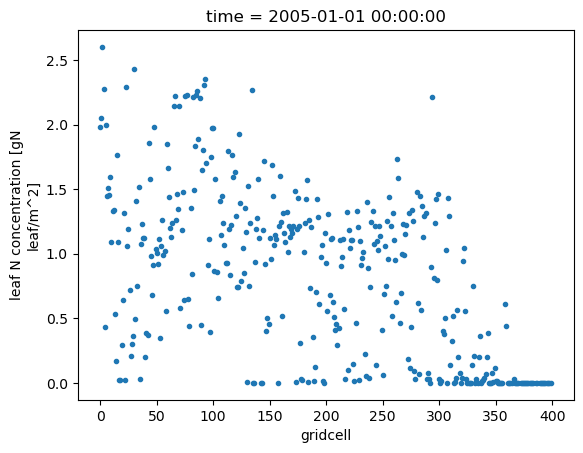

In [40]:
lnc.isel(ens=0,
        time=0).plot.line(".")

In [5]:
param, var = dashboard_wrangling('leafcn','LNC')

In [42]:
param.shape

(500, 32)

In [43]:
var.shape

(500,)

In [45]:
lnc = var.values

In [46]:
from scipy import stats

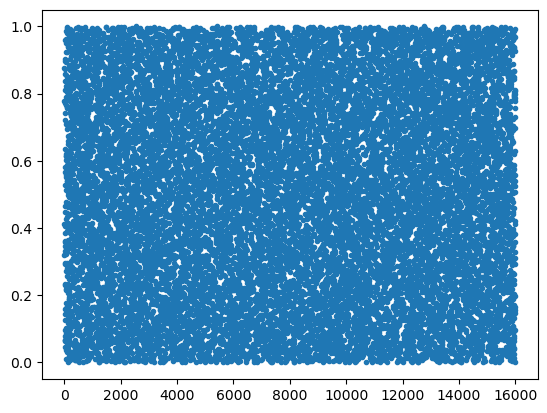

In [55]:
plt.plot(param.ravel(), ".")

In [56]:
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)

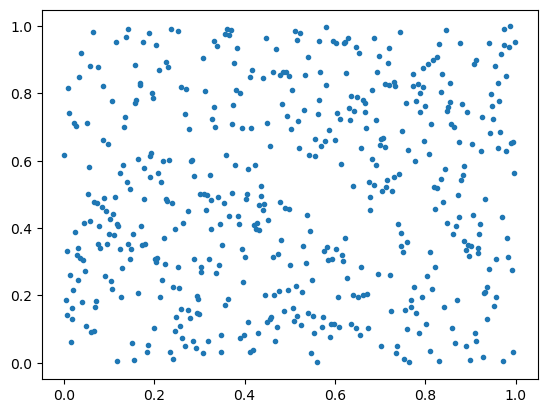

In [66]:
plt.plot(df['FUN_fracfixers'].values, param[:,0], ".")

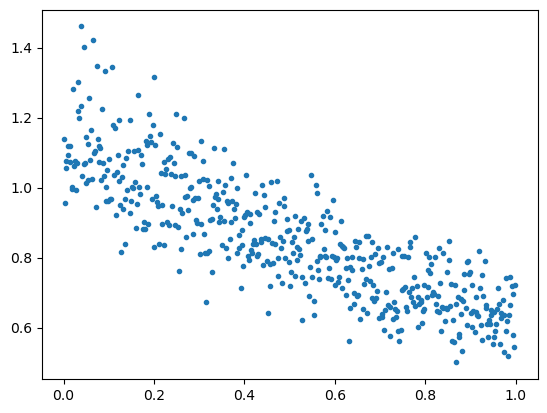

In [67]:
plt.plot(df['leafcn'].values, lnc, ".")

In [71]:
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        Parameter Data.       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# x parameter data for assessment
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
# the only dimension here is the 'member' aka file index id [LCH0001-500]
# convert to xr.ds
params = xr.Dataset(df)



In [72]:
params

<xarray.Dataset> Size: 132kB
Dimensions:              (member: 500)
Coordinates:
  * member               (member) object 4kB 'LHC0001' 'LHC0002' ... 'LHC0500'
Data variables: (12/32)
    FUN_fracfixers       (member) float64 4kB 0.7783 0.3193 ... 0.2621 0.4221
    KCN                  (member) float64 4kB 0.358 0.5488 ... 0.9123 0.8392
    a_fix                (member) float64 4kB 0.255 0.6302 ... 0.5339 0.1443
    crit_dayl            (member) float64 4kB 0.4012 0.27 ... 0.9974 0.6571
    d_max                (member) float64 4kB 0.7978 0.5361 ... 0.9076 0.4009
    fff                  (member) float64 4kB 0.1301 0.6792 ... 0.9918 0.02798
    ...                   ...
    stem_leaf            (member) float64 4kB 0.1138 0.1273 ... 0.3328 0.347
    sucsat_sf            (member) float64 4kB 0.7982 0.3947 ... 0.3526 0.6515
    theta_cj             (member) float64 4kB 0.03646 0.09374 ... 0.8429 0.5055
    tpu25ratio           (member) float64 4kB 0.3936 0.04108 ... 0.716 0.2124
    tpuse_sf             (member) float64 4kB 0.07896 0.2756 ... 0.353 0.3634
    wc2wjb0              (member) float64 4kB 0.6846 0.8785 ... 0.3581 0.1567

In [ ]:
# Create an empty list to store the columns
columns = []
# Iterate over each data variable
for var_name in params.data_vars:
    # Extract the values for the current variable
    var_values = params[var_name].values
    # Stack the values into a single column
    stacked_values = var_values.ravel()
    # Append the stacked column to the list of columns
    columns.append(stacked_values)
# Stack all columns horizontally to create the final numpy data array
numpy_params = np.column_stack(columns)
numpy_params.shape

In [81]:
def param_wrangling():
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        Parameter Data.       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # x parameter data for assessment
    df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
    # the only dimension here is the 'member' aka file index id [LCH0001-500]
    # convert to xr.ds
    params = xr.Dataset(df)

    # list comprehension no need for empty list
    columns = [params[v].values for v in params.data_vars]

    # iterate over params
    return np.array(columns).T

In [85]:
X = param_wrangling()

In [86]:
X.shape

(500, 32)

In [70]:
np.corrcoef(df['leafcn'].values, lnc)**2

array([[1.       , 0.7132634],
       [0.7132634, 1.       ]])

In [54]:
# I want 32 vectors, 500 long
# numerical index of each param
# r^2
for i, p in enumerate(param.T):
    print(i, np.corrcoef(p, lnc)[0,1]**2)

0 5.9258077218546594e-05
1 0.01101566416176732
2 0.005755648608572309
3 0.00534909932567713
4 0.004167846072489683
5 1.6300173373366583e-05
6 0.0003664788952901629
7 0.00025453493277292357
8 7.147831203817569e-05
9 0.0015893310316536873
10 0.002034335539163416
11 0.001064389678159452
12 0.001017161384307417
13 0.00134048091440128
14 8.373667558662684e-05
15 0.0002177509109774711
16 0.0018733734838025683
17 0.0002231498583069036
18 1.4784395763785887e-06
19 0.0011303042922384944
20 0.005404689028884767
21 0.013464206448792098
22 0.0013674803358140737
23 0.0004901669684549187
24 0.0005157847554484654
25 0.0022372851265447767
26 0.0024145377832474296
27 6.56365916827299e-05
28 0.0028560926363826143
29 0.00011240009456989255
30 0.002222189879815391
31 0.0010706771772724618


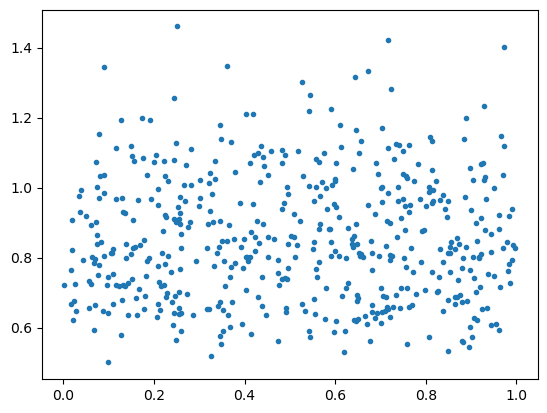

In [44]:
plt.plot(param[:,15], var, ".")

#### GPR

In [87]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# data for splitting
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    var,
                                                    test_size=0.2,
                                                   # setting a seed
                                                    random_state=0)

In [88]:
X_train.shape

(400, 32)

##### Kernel

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    Kernel Specs No Tuning    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define the kernel with suitable hyperparameters
# R^2:Training R^2: 0.01
kernel = ConstantKernel(3.0, constant_value_bounds=(1e-6, 1e4)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e8)) \
         + ConstantKernel(3.0, constant_value_bounds=(1e-6, 1e4)) * Matern(length_scale=1.0, nu=1.5) \
         + ConstantKernel(3.0, constant_value_bounds=(1e-6, 1e4)) * RationalQuadratic(length_scale=1.0, alpha=0.1) \
         + ConstantKernel(3.0, constant_value_bounds=(1e-6, 1e4)) * ExpSineSquared(length_scale=1.0, periodicity=1.0) \
         + WhiteKernel(noise_level=3.0, noise_level_bounds=(1e-6, 1e4))

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        GPR Model Recipe      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
gp_model = GaussianProcessRegressor(kernel=kernel,
                                    n_restarts_optimizer=20,
                                    random_state=42,
                                    normalize_y = True)

# Scale the normalized target variable y to the desired range
scaler = MinMaxScaler(feature_range=(20, 40))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit the Model        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Fit the model to the training data 
gp_model = gp_model.fit(X_train, y_train_scaled)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Get Predictions      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Make predictions
y_pred, y_std = gp_model.predict(X_test, return_std=True)

# Inverse transform the scaled predictions to the original scale
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calli

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Collect Metrics      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Verify training score
train_score = gp_model.score(X_train, y_train_scaled)
    
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Calculate R^2
r2_train = r2_score(y_test, y_pred)
# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

# Create a DataFrame to store the results for plotting
results_df = pd.DataFrame({
     'y_pred': y_pred,
    'y_std': y_std,
    'y_test': y_test,
     'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
})

# Add metrics to the DataFrame
results_df['R^2'] = r2_train
results_df['RMSE'] = rmse_train
results_df['Mean Absolute Error'] = mae
    
# Print Training Metrics
print("Training R^2:", r2_train)
print("Training RMSE:", rmse_train)
print("Mean Absolute Error:", mae)
print("Training Score:", train_score)

Training R^2: -0.0068289981672369215
Training RMSE: 0.1939771989777019
Mean Absolute Error: 0.15622071863804046
Training Score: 0.046027505375475175


In [25]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# data for splitting
X_train, X_test, y_train, y_test = train_test_split(param,
                                                    var,
                                                    test_size=0.2,
                                                   # setting a seed
                                                    random_state=0)

In [31]:
# this is showing us our wrangling is not working correctly
y_train.values 

array([0.94449362, 0.64842984, 0.81453533, 0.63472275, 1.1658383 ,
       1.08617451, 1.03640581, 0.72585474, 0.64845206, 0.67439074,
       0.71432794, 1.06998345, 0.7631888 , 1.16894026, 0.95651789,
       0.70606559, 1.03850263, 0.8816959 , 0.80073799, 0.67332416,
       0.97878494, 0.65720214, 0.64650815, 0.8440537 , 0.64459011,
       1.06470124, 0.80538482, 0.85920677, 0.99963864, 1.03237023,
       1.10931561, 0.69500654, 0.76660383, 0.77391799, 1.12304188,
       0.60984878, 0.89548088, 0.58890104, 0.87274658, 0.78645877,
       0.63486871, 0.88153914, 1.0208193 , 0.68774682, 0.65829159,
       0.81342371, 0.74433728, 0.7987506 , 0.75929228, 0.88651485,
       1.10358591, 0.69019595, 0.70081472, 0.82816212, 0.82720707,
       0.65378294, 0.73847028, 1.02614401, 1.10359596, 0.91945526,
       1.11643467, 1.22465875, 0.69648186, 0.63336282, 0.92606547,
       0.70185216, 0.90839784, 0.9510528 , 0.9671931 , 0.90211513,
       0.56162589, 0.84394412, 0.87977336, 1.03406305, 0.81611

In [89]:
gp_model = GaussianProcessRegressor(normalize_y=True
                                   )

In [90]:
gp_model.fit(X_train, y_train)

GaussianProcessRegressor(normalize_y=True)

In [91]:
y_pred = gp_model.predict(X_test)

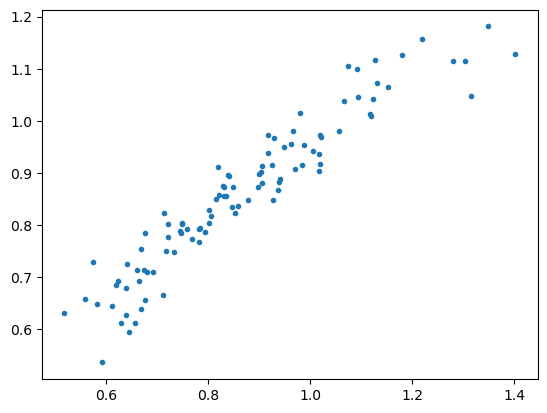

In [92]:
plt.plot(y_test, y_pred, ".")

In [13]:
def train_emulator(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=1, 
                        length_scale_bounds=(1e-4, 1e8))

    gp_model = GaussianProcessRegressor(kernel=kernel,
                                        n_restarts_optimizer=20,
                                        random_state=42,
                                        normalize_y=True)

    # Scale the normalized target variable y to the desired range
    scaler = MinMaxScaler(feature_range=(20, 40))
    
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gp_model = gp_model.fit(X_train, y_train_scaled)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Make predictions
    y_pred, y_std = gp_model.predict(X_test, return_std=True)

    
    # Inverse transform the scaled predictions to the original scale
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Verify training score
    train_score = gp_model.score(X_train, y_train_scaled)

    # Accuracy Score
   # accuracy = accuracy_score(y_test, y_pred)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate R^2
    r2_train = r2_score(y_test, y_pred)
    
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

    # Create a DataFrame to store the results for plotting
    results_df = pd.DataFrame({
        'y_pred': y_pred,
        'y_std': y_std,
        'y_test': y_test,
        'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
    })

    # Add metrics to the DataFrame
    results_df['R^2'] = r2_train
    results_df['RMSE'] = rmse_train
    #results_df['Accuracy Score'] = accuracy
    results_df['Mean Absolute Error'] = mae
    
    
    
    # Print Training Metrics
  #  print("Accuracy Score:", accuracy)
    print("Training R^2:", r2_train)
    print("Training RMSE:", rmse_train)
    print("Mean Absolute Error:", mae)
    print("Training Score:", train_score)

    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Visualize Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Calculate the z-score for the 99.7% confidence interval
    # 99.7th percentile (three standard deviations)
    z_score = norm.ppf(0.99865)  
    
    # Sort X_test and corresponding predictions for plotting
    sorted_indices = np.argsort(X_test[:, 0])
    X_test_sorted = X_test[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    y_std_sorted = y_std[sorted_indices]
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    plt.plot(X_test_sorted[:, 0],
             y_pred_sorted,
             color='#134611',
             label='GPR Prediction')
    
    # when turned on, it's not showing regression line, something went wrong in scaler in think
   # plt.ylim(20, 40) 
    
    # applying z-score for 99.7% CI
    plt.fill_between(X_test_sorted[:, 0],
                     y_pred_sorted - z_score * y_std_sorted, y_pred_sorted + z_score * y_std_sorted,
                     alpha=0.5, 
                     color='#9d6b53',
                     label = '95% Confidence Interval')
    
    plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
    plt.ylabel('Variable: Leaf Nitrogen Concentration')
    plt.title('Gaussian Process Regression Uncertainty Estimation')
    
    plt.legend()
    plt.show()

Training R^2: -0.005360674779886665
Training RMSE: 0.1938357026672743
Mean Absolute Error: 0.1561106260971481
Training Score: 1.0


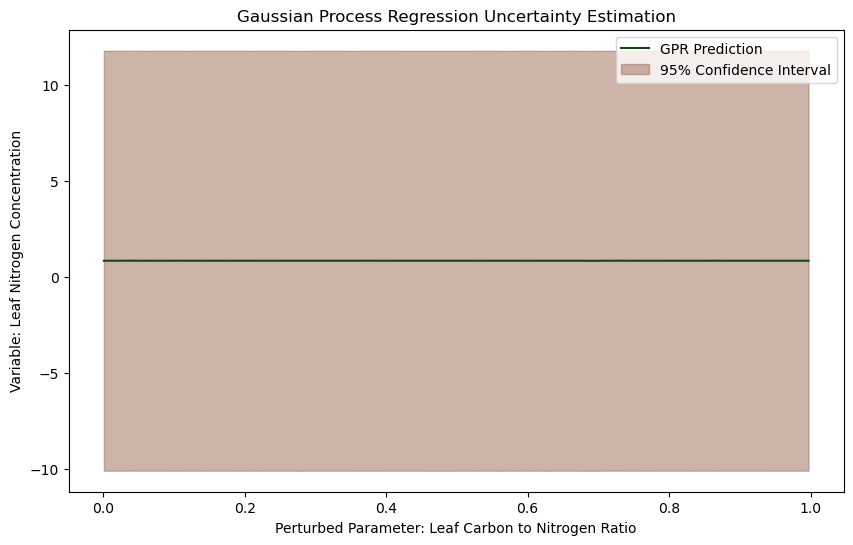

In [14]:
emulation2 = train_emulator(param, var)

#### Hyperparameter Tuning Approach

In [15]:
# Define a custom scorer for R^2 score
scorer = make_scorer(r2_score)
cv_folds = 5

In [22]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    kernel specifications     ----  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# defining kernels
linear = ConstantKernel(constant_value=3.0, constant_value_bounds=(1e-2, 1e4)) \
         * Linear

poly = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) \
        * Polynomial 

# RBF kernel in GPflow is equivalent to scikit-learn's RBF kernel
RBF = RBF(length_scale=1,length_scale_bounds=(1e-4, 1e8))

# Matern32 in GPflow is equivalent to scikit-learn's Matern with nu=1.5
Matern32 = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) * Matern(length_scale=1, nu=1.5)

# Matern52 in GPflow is equivalent to scikit-learn's Matern with nu=2.5
Matern52 = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) * Matern(length_scale=1, nu=2.5)

# Bias kernel in GPflow is equivalent to scikit-learn's WhiteKernel
bias = WhiteKernel(noise_level= 3, noise_level_bounds=(1e-2, 1e4))

In [23]:
# Define the parameter grid with adjusted ranges for length_scale
param_grid = {
    'kernel': [linear, RBF, Matern32, poly, bias],
    # Example values for alpha (adjust as needed)
    'alpha': [1e-6, 1e-5, 1e-4, 1e-3],  
    # Adjust the range for RBF length_scale
    'kernel__k2__length_scale': [1e-8, 1e-7, 1e-6, 1e-5],
    # Adjust the range for ConstantKernel
    'kernel__k1__k1__constant_value': [0.1, 1.0, 2.0, 3.0],  
    # Adjust the range for WhiteKernel noise_level
    'kernel__k2__noise_level': [0.01, 0.1, 1.0, 3.0],
    # Adjust the range for RationalQuadratic alpha
    'kernel__k1__k2__alpha': [0.1, 1.0, 2.0],
    # Adjust the range for Polynomial degree
    'kernel__k1__k1__k2__degree': [2, 3, 4, 5, 6]  
}

In [24]:
param_grid

TypeError: loop of ufunc does not support argument 0 of type function which has no callable sqrt method

In [ ]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(GaussianProcessRegressor(),
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='r2',
                           # do in parallel
                           n_jobs=-1)


In [ ]:
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
r2_score = best_model.score(y_test, y_pred)
print("Best R^2 Score:", r2_score)
print("Best Hyperparameters:", best_params)

#### Linnia's Kernel Recipe, not specs tho

R-squared value (Combined Tree Kernel 1): -0.006963103407625626


R-squared value (Combined Grass Kernel 3): -0.006963099087646141

In [ ]:
# Define individual kernels
# NEED TO CORRECT LINEAR KERNEL
# linear and rbf are identical - not useful

linear_kernel = ConstantKernel() * RBF()
rbf_kernel = ConstantKernel() * RBF()
poly_kernel = ConstantKernel() * RationalQuadratic()
matern_kernel = ConstantKernel() * Matern()
noise_kernel = WhiteKernel()


# Combine kernels in various ways
# Option 1: Linnia Grass kernel, Sum of kernels
# Combine kernels using Sum and Product operations
combined_kernel_1 = Sum(linear_kernel, rbf_kernel)
combined_kernel_1 = Sum(combined_kernel_1, poly_kernel)
combined_kernel_1 = Sum(combined_kernel_1, matern_kernel)
combined_kernel_1 = Sum(combined_kernel_1, noise_kernel)

# Option 2: Product of kernels
combined_kernel_2 = Product(linear_kernel, rbf_kernel)
#combined_kernel_2 = Product(combined_kernel_2, poly_kernel)
#combined_kernel_2 = Product(combined_kernel_2, matern_kernel)
#combined_kernel_2 = Product(combined_kernel_2, noise_kernel)

# Option 3: Linnia Tree kernel
combined_kernel_3 = Sum(combined_kernel_2, matern_kernel)
combined_kernel_3 = Sum(combined_kernel_3, noise_kernel)


# Initialize Gaussian Process Regressors with the custom kernels
gpr_model_1 = GaussianProcessRegressor(kernel=combined_kernel_1, n_restarts_optimizer=20, random_state=42)
#gpr_model_2 = GaussianProcessRegressor(kernel=combined_kernel_2, n_restarts_optimizer=20, random_state=42)
gpr_model_3 = GaussianProcessRegressor(kernel=combined_kernel_3, n_restarts_optimizer=20, random_state=42)

# Fit the models to the training data
gpr_model_1.fit(X_train, y_train)
gpr_model_3.fit(X_train, y_train)

# Predict on the test set
y_pred_1 = gpr_model_1.predict(X_test)
y_pred_3 = gpr_model_3.predict(X_test)

# Calculate R-squared values
r2_1 = r2_score(y_test, y_pred_1)
r2_3 = r2_score(y_test, y_pred_3)

# Print the R-squared values
print("R-squared value (Combined Kernel 1):", r2_1)
print("R-squared value (Combined Kernel 3):", r2_3)